# Хакатон. Учебная задача

## Подготовка данных


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random
from pathlib import Path

import pandas as pd
import torch

from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
#% matplotlib inline

In [3]:
# Загружаем файл и конвертируем в список словарей
with open('/content/drive/MyDrive/Hacaton/geo-reviews-dataset-2023.tskv', 'r', encoding='utf-8') as file:
    lines = [dict(item.split('=', 1) for item in line.split('\t')) for line in file]

columns = [
    'address',
    'name_ru',
    'rating',
    'rubrics',
    'text'
    ]

# Конвертим в DF
geo_df = pd.DataFrame(lines, columns=columns)

geo_df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


In [4]:
# Чистим данные и удаляем 200 записей с рейтингом 0
geo_df.dropna(subset=['text', 'name_ru', 'rating'], inplace=True)
geo_df = geo_df.drop_duplicates(subset=['text']).reset_index(drop=True)
geo_df['text'] = geo_df['text'].str.replace('\\n', ' ')

geo_df.drop(geo_df[(geo_df['rating'] == '0.')].index, inplace=True)

In [5]:
print('Оставшееся число записей', geo_df.shape[0])

Оставшееся число записей 498718


In [6]:
geo_df['rating'].value_counts()

,count
rating,
5.,389586
4.,41111
1.,34298
3.,21652
2.,12071


"Ребалансируем" датасет по наименьшей группе в рейтинге

In [7]:
# Группируем данные по рейтингу и семплируем по размеру наименьшей группы
geo_df = geo_df.groupby('rating')
geo_df = pd.DataFrame(geo_df.apply(lambda x: x.sample(geo_df.size().min()).reset_index(drop=True)))


<ipython-input-7-5c2dee46c0d2>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  geo_df = pd.DataFrame(geo_df.apply(lambda x: x.sample(geo_df.size().min()).reset_index(drop=True)))


Получаем примерно 60000 записей:

In [8]:
geo_df['rating'].value_counts()

,count
rating,
1.,12071
2.,12071
3.,12071
4.,12071
5.,12071


Количество уникальных категорий 1176


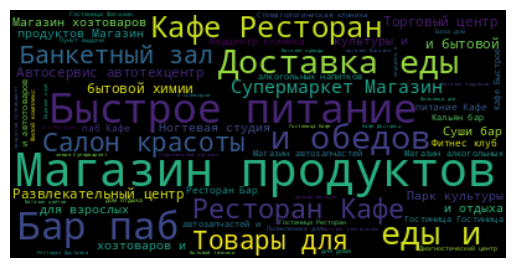

In [9]:
rubrics = set(x for lst in geo_df['rubrics'].apply(lambda x: x.split(';')) for x in lst)
print('Количество уникальных категорий', len(rubrics))

text = " ".join(x for lst in geo_df['rubrics'].apply(lambda x: x.split(';')) for x in lst)

cloud_stopwords = set(STOPWORDS)

wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="black", stopwords=cloud_stopwords).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
images_path = Path('/content/drive/MyDrive/Hacaton/finetune/imgs/finetune_gpt/')
images_path.mkdir(parents=True, exist_ok=True)


data_path = Path('/content/drive/MyDrive/Hacaton/finetune/data/finetune_gpt/')
data_path.mkdir(parents=True, exist_ok=True)

seed = 55
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)


In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [12]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from pathlib import Path

class TextGenerator:
    def __init__(self, model_name='fine_tuned_model', data_path=data_path):
        """
        Инициализация модели и токенизатора.
        Загружаем модель и токенизатор из указанного пути.
        """
        model_path = Path(data_path) / model_name
        self.tokenizer = GPT2Tokenizer.from_pretrained(str(model_path)).to(device)
        self.model = GPT2LMHeadModel.from_pretrained(str(model_path)).to(device)
        self.model.eval()

    def generate_text(self,
                    name_ru: str,
                    rubrics: str,
                    rating: int,
                    max_length=100,
                    num_return_sequences=1,
                    temperature=1.0,
                    top_k=0,
                    top_p=1.0,
                    do_sample=False):

        prompt_text = f"<name_ru> {name_ru} <rubrics> {rubrics} <rating> {rating} {self.tokenizer.eos_token} <text> "

        encoded_input = self.tokenizer.encode(prompt_text, return_tensors='pt')

        outputs = self.model.generate(
            encoded_input,
            max_length=max_length + len(encoded_input[0]),
            num_return_sequences=num_return_sequences,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=do_sample,
            no_repeat_ngram_size=2
        )

        # Декодирование результатов
        all_texts = [self.tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

        # Удаление входных данных из текстов
        prompt_length = len(self.tokenizer.decode(encoded_input[0], skip_special_tokens=True))
        trimmed_texts = [text[prompt_length:] for text in all_texts]

        return {
            "full_texts": all_texts,
            "generated_texts": trimmed_texts
        }

In [13]:
tuner_path = Path(data_path)

model_name='ai-forever/rugpt3small_based_on_gpt2'
cache_dir='model_cache'
output_name = 'fine_tuned_model_gpt_2'

tokenizer = GPT2Tokenizer.from_pretrained(model_name, cache_dir=str(data_path / cache_dir))
model = GPT2LMHeadModel.from_pretrained(model_name, cache_dir=str(data_path / cache_dir)).to(device)

geo_df['input'] = geo_df.apply(lambda row: f"<name_ru> {row['name_ru']} <rubrics> {row['rubrics']} <rating> {row['rating']} {tokenizer.eos_token}", axis=1)

# Добавление к целевому тексту токена окончания строки
geo_df['output'] = geo_df.apply(lambda row: f" <text> {row['text']} {tokenizer.eos_token}", axis=1)

# Подготовка пути для сохранения данных
dataset_path = data_path / 'train_dataset.txt'
# Запись данных в файл
with dataset_path.open('w', encoding='utf-8') as file:
    for input_text, target_text in zip(geo_df['input'], geo_df['output']):
        file.write(input_text + ' ' + target_text + '\n')

train_dataset = TextDataset(tokenizer=tokenizer,
                            file_path=str(dataset_path),
                            block_size=256
                            )

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm=False
                                                )

training_args = TrainingArguments(output_dir=str(data_path / 'fine_tuned_model_gpt_2'),
                                  overwrite_output_dir=True,
                                  num_train_epochs=4,
                                  per_device_train_batch_size=4,
                                  save_steps=15000,
                                  learning_rate=5e-5,
                                  save_total_limit=2,
                                  logging_dir=str(data_path / 'logs')
                                  )

trainer = Trainer(model,
                  args=training_args,
                  data_collator=data_collator,
                  train_dataset=train_dataset,
                 )

trainer.train()
# Сохранение обученной модели и токенизатора
model.save_pretrained(str(data_path / output_name))
tokenizer.save_pretrained(str(data_path / output_name))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/551M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss


KeyboardInterrupt: 

In [ ]:
name = 'Гарцуюший Пони'
rubrics = 'Кафе;Веранда'
rating = 2

generator = TextGenerator(
    model_name='fine_tuned_model_gpt_2',
    data_path=data_path
)
generated_texts = generator.generate_text(
    name_ru=name,
    rubrics=rubrics,
    rating=rating,
    max_length=100,
    num_return_sequences=3,
    do_sample=True,
    temperature=0.95,
    top_k=10,
    top_p=0.95
)
for i, text in enumerate(generated_texts['generated_texts']):
    print(f"Generated Text {i+1}: {text}")